## Task 1

In [ ]:
import pyspark
from pyspark.sql import functions as F

spark = pyspark.sql.SparkSession.builder \
    .appName("Project 4") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

In [46]:
df = spark.read.csv('./data/2009.csv', header=True, inferSchema=True)

In [47]:
from pathlib import Path

data_path = "./output/2009.parquet"
data_file = Path(data_path)
if not data_file.exists():

    df = spark.read.csv('./data/2009.csv', header=True)
    print(f"Total flights: {df.count()}")

    df_2009 = df.filter(F.year(F.col("FL_DATE")) == 2009)
    print(f"2009 flights: {df_2009.count()}")

    df_2009.write.partitionBy("FL_DATE").mode("overwrite").parquet(data_path)

df_flights = spark.read.load(data_path)

## Task 2

In [48]:

df_renamed = df_flights \
    .withColumnRenamed("FL_DATE", "FlightDate") \
    .withColumnRenamed("OP_CARRIER", "UniqueCarrier") \
    .withColumnRenamed("OP_CARRIER_FL_NUM", "FlightNum") \
    .withColumnRenamed("ORIGIN", "Origin") \
    .withColumnRenamed("DEST", "Destination") \
    .withColumnRenamed("CRS_DEP_TIME", "ScheduledDepartureTime") \
    .withColumnRenamed("DEP_TIME", "DepartureTime") \
    .withColumnRenamed("DEP_DELAY", "DepartureDelay") \
    .withColumnRenamed("TAXI_OUT", "TaxiOut") \
    .withColumnRenamed("WHEELS_OFF", "WheelsOff") \
    .withColumnRenamed("WHEELS_ON", "WheelsOn") \
    .withColumnRenamed("TAXI_IN", "TaxiIn") \
    .withColumnRenamed("CRS_ARR_TIME", "ScheduledArrivalTime") \
    .withColumnRenamed("ARR_TIME", "ArrivalTime") \
    .withColumnRenamed("ARR_DELAY", "ArrivalDelay") \
    .withColumnRenamed("CANCELLED", "Cancelled") \
    .withColumnRenamed("CANCELLATION_CODE", "CancellationCode") \
    .withColumnRenamed("DIVERTED", "Diverted") \
    .withColumnRenamed("CRS_ELAPSED_TIME", "ScheduledElapsedTime") \
    .withColumnRenamed("ACTUAL_ELAPSED_TIME", "ActualElapsedTime") \
    .withColumnRenamed("AIR_TIME", "AirTime") \
    .withColumnRenamed("DISTANCE", "Distance") \
    .withColumnRenamed("CARRIER_DELAY", "CarrierDelay") \
    .withColumnRenamed("WEATHER_DELAY", "WeatherDelay") \
    .withColumnRenamed("NAS_DELAY", "NASDelay") \
    .withColumnRenamed("SECURITY_DELAY", "SecurityDelay") \
    .withColumnRenamed("LATE_AIRCRAFT_DELAY", "LateAircraftDelay") \
    .drop("Unnamed: 27")

df_renamed.show()

+-------------+---------+------+-----------+----------------------+-------------+--------------+-------+---------+--------+------+--------------------+-----------+------------+---------+----------------+--------+--------------------+-----------------+-------+--------+------------+------------+--------+-------------+-----------------+----------+
|UniqueCarrier|FlightNum|Origin|Destination|ScheduledDepartureTime|DepartureTime|DepartureDelay|TaxiOut|WheelsOff|WheelsOn|TaxiIn|ScheduledArrivalTime|ArrivalTime|ArrivalDelay|Cancelled|CancellationCode|Diverted|ScheduledElapsedTime|ActualElapsedTime|AirTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|FlightDate|
+-------------+---------+------+-----------+----------------------+-------------+--------------+-------+---------+--------+------+--------------------+-----------+------------+---------+----------------+--------+--------------------+-----------------+-------+--------+------------+------------+--------+---

In [49]:
df_with_features = df_renamed \
    .withColumn("DayOfWeek", F.dayofweek(F.col("FlightDate"))) \
    .withColumn("Month", F.month(F.col("FlightDate")))

In [50]:
# null_columns = [c for c in df_with_features.columns if df_with_features.filter(F.col(c).isNull()).count() > 0]
# null_columns

In [51]:
delays = [
    'DepartureDelay',
    'ArrivalDelay',
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay']
times = [
    'DepartureTime',
    'TaxiOut',
    'WheelsOff',
    'WheelsOn',
    'TaxiIn',
    'ArrivalTime',
    'ActualElapsedTime',
    'AirTime']
cancellation = [
    'CancellationCode'
]

df_cleaned = df_with_features \
    .fillna("0", subset=delays) \
    .fillna("", subset=cancellation)

for col_name in times:
    df_cleaned = df_cleaned.withColumn(col_name, F.when((F.col("Cancelled") == 1) | (F.col("Diverted") == 1.0), 0).otherwise(F.col(col_name)))

df_cleaned = df_cleaned.filter(F.col("Diverted") == 0.0)

In [52]:
from functools import reduce

all_rows_count = df_cleaned.count()

not_null_condition = reduce(lambda x, y: x & y, [F.col(c).isNotNull() for c in df_cleaned.columns])
df_cleaned = df_cleaned.filter(not_null_condition)
cleaned_rows_count = df_cleaned.count()

print(f"Found {all_rows_count - cleaned_rows_count} rows with unjustified NULL values. Removing them.")

Found 1 rows with unjustified NULL values. Removing them.


In [53]:
# null_condition = [(F.col(c).isNull()) for c in df_cleaned.columns]
# df_with_nulls = df_cleaned.filter(reduce(lambda x, y: x | y, null_condition))
# df_with_nulls.show()

## Task 3

Top 10 carriers by flight count:
+-------------+-------+
|UniqueCarrier|  count|
+-------------+-------+
|           WN|1127045|
|           AA| 548194|
|           OO| 544843|
|           MQ| 434577|
|           DL| 424982|
|           US| 411273|
|           UA| 375501|
|           XE| 308340|
|           EV| 297874|
|           NW| 291856|
+-------------+-------+



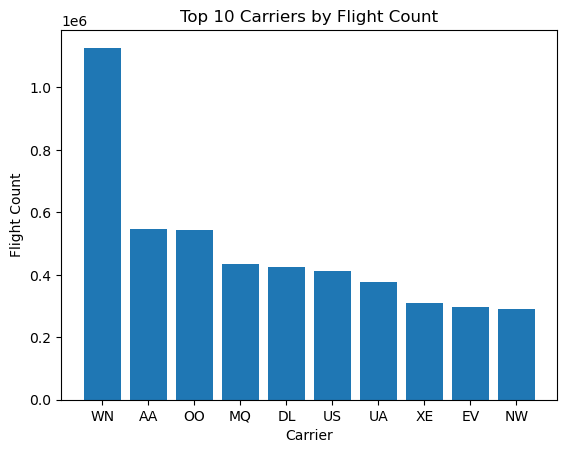

In [54]:
top_carriers = df_cleaned.groupBy("UniqueCarrier").count().orderBy(F.desc("count")).limit(10)
print("Top 10 carriers by flight count:")
top_carriers.show()

import matplotlib.pyplot as plt

pdf = top_carriers.toPandas()
plt.figure()
plt.bar(pdf['UniqueCarrier'], pdf['count'])
plt.title('Top 10 Carriers by Flight Count')
plt.xlabel('Carrier')
plt.ylabel('Flight Count')
plt.show()

Cancellation reasons
+----------------+-----+
|CancellationCode|count|
+----------------+-----+
|               B|36651|
|               A|35568|
|               C|14799|
|               D|   20|
+----------------+-----+



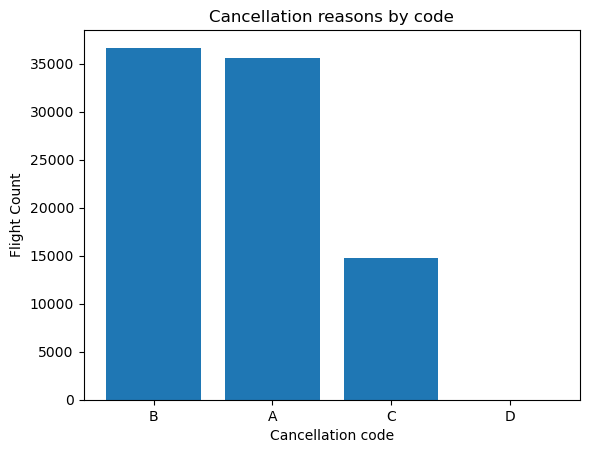

In [55]:
cancellation_counts = df_cleaned.filter(F.col("Cancelled") == 1.0) \
                        .groupBy("CancellationCode").count().orderBy(F.desc("count")).limit(10)

print("Cancellation reasons")
cancellation_counts.show()

pdf = cancellation_counts.toPandas()
plt.figure()
plt.bar(pdf['CancellationCode'], pdf['count'])
plt.title('Cancellation reasons by code')
plt.xlabel('Cancellation code')
plt.ylabel('Flight Count')
plt.show()

In [ ]:
total_count = cancellation_counts.agg(F.sum("count")).collect()[0][0]

df = cancellation_counts.withColumn("distribution", (F.col("count") / total_count) * 100)

max_count = df.agg(F.max("count")).collect()[0][0]
min_count = df.agg(F.min("count")).collect()[0][0]
imbalance_ratio = max_count / min_count

print("Class distribution")
df.show()
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")


Class distribution
